In [1]:
import warnings
warnings.simplefilter("always")

# Run this again after editing submodules so Colab uses the updated versions
from citylearn import  CityLearn
from pathlib import Path
from TD3 import Agent as Agent
import numpy as np                                                                                                                                                                                      
import torch
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from utils import agent_checkpoint_cost
import seaborn as sns
import os

/usr/local/lib/python3.9/site-packages/diffcp/cones.py:7: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if StrictVersion(scs.__version__) >= StrictVersion('3.0.0'):


In [2]:
# Load environment
climate_zone = 1
end_time = 8759 # total number of hours to train for
cost_analysis = 24 # analyze costs every x hours
checkpoint = 24 * 7 # save parameters every x hours

params = {'data_path':Path("data/Climate_Zone_"+str(climate_zone)), 
        'building_attributes':'building_attributes.json', 
        'weather_file':'weather_data.csv', 
        'solar_profile':'solar_generation_1kW.csv', 
        'carbon_intensity':'carbon_intensity.csv',
        'building_ids':["Building_"+str(i) for i in [1,2,3,4,5,6,7,8,9]],
        'buildings_states_actions':'buildings_state_action_space.json', 
        'simulation_period': (0, end_time), 
        'cost_function': ['ramping','1-load_factor','average_daily_peak','peak_demand','net_electricity_consumption','carbon_emissions'], 
        'central_agent': False,
        'cost_analysis' : cost_analysis,
        'save_memory': False }

# Contain the lower and upper bounds of the states and actions, to be provided to the agent to normalize the variables between 0 and 1.
env = CityLearn(**params)
env.pretrain_baseline_model((0, end_time))

observations_spaces, actions_spaces = env.get_state_action_spaces()

# Provides information on Building type, Climate Zone, Annual DHW demand, Annual Cooling Demand, Annual Electricity Demand, Solar Capacity, and correllations among buildings
building_info = env.get_building_information()

Time taken to add RBC pretrained model (sec): 15.466


In [3]:
def get_mse_critic():
    if not agent.did_i_just_finish_training():
            return None, None
    try:
        data = {}
        NUM_DAYS = len(agent.critic_optim.debug['ramping_cost'])

        for key, _d in agent.critic_optim.debug.items():
            data[key] = []
            for day in _d:
                data[key].append(day.value)
            data[key] = np.reshape(data[key], (NUM_DAYS * 24))

        rc = data['ramping_cost']
        peak = data['peak_net_electricity_cost']
        ec = data['electricity_cost']

        A = np.vstack((-rc, -peak)).T
        y = np.reshape(agent.critic_optim.problem.param_dict['y_r'].value, (NUM_DAYS * 24))

        x, residuals, rank, s = np.linalg.lstsq(A, y, rcond=None)
        # print(f"Rank: {rank}\tCondition Number: {np.linalg.cond(A)}")
        # print(f"MSE across {NUM_DAYS} days: {round(np.linalg.norm(A@x - y), 5)}")
        return round(np.linalg.norm(A@x - y), 5), round(np.linalg.cond(A), 3)
    except:
        return None, None

In [49]:
env._get_ob().shape

(9, 30)

In [4]:
params_agent = {'building_ids':["Building_"+str(i) for i in [1,2,3,4,5,6,7,8,9]],
                 'buildings_states_actions':'buildings_state_action_space.json', 
                 'building_info':building_info,
                 'observation_spaces':observations_spaces,
                 'agent_checkpoint' : checkpoint,
                 'action_spaces':actions_spaces}

# Instantiating the control agent(s)
rewards = []
critic_mse = [] # only last building to be added MSE will be recorded

agent = Agent(**params_agent)

state = env.reset()
done = False

ZO_iRL_costs = np.load("ZOiRL_cost_curve.npy")

with tqdm(total=end_time) as pbar:
    while not done:
        
        # get agent
        # day_type = env.buildings['Building_1'].sim_results['day'][env.time_step]
        # agent = agents.get_agent(day_type)
        # get agent
        
        action, _ = agent.select_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.add_to_buffer(state, action, reward, next_state, done)
        state = next_state

        rewards.append(reward)

        try:
            mse, condition = get_mse_critic()
            pim = round(100 * (env.costs_periodic[-1]['total'] - ZO_iRL_costs[env.time_step]) / ZO_iRL_costs[env.time_step], 3)
            txt = f"Cost: {round(env.costs_periodic[-1]['total'], 5)} , ZOiRL: {round(ZO_iRL_costs[env.time_step], 3)} , %improvement: {pim}"
            if len(critic_mse) > 0:
                txt += f"\tCritic MSE: {critic_mse[-1][0]}\tCondition number: {critic_mse[-1][1]}"
                
            if mse is not None:
                critic_mse.append([mse, condition])
                
            pbar.set_description(txt)
        except:
            pass
        
        pbar.update(1)

rewards = np.array(rewards)

Cost: 1.41259 , ZOiRL: 1.406 , %improvement: 0.495:   5%| | 479/8759 [00:30<20:3

E2E	Building: 8, r: 20

Cost: 1.40576 , ZOiRL: 1.403 , %improvement: 0.216:   5%| | 480/8759 [06:24<180:

Time taken for training: 353.77
Building 8: -4798.927

Cost: 1.3802 , ZOiRL: 1.373 , %improvement: 0.547	Critic MSE: 1014.19216	Conditi

E2E	Building: 8, r: 22

Cost: 1.37283 , ZOiRL: 1.37 , %improvement: 0.172	Critic MSE: 1014.19216	Conditi

Time taken for training: 398.35
Building 8: -1396.23

Cost: 1.34176 , ZOiRL: 1.337 , %improvement: 0.337	Critic MSE: 2119.67569	Condit

E2E	Building: 8, r: 22

Cost: 1.33741 , ZOiRL: 1.335 , %improvement: 0.156	Critic MSE: 2119.67569	Condit

Time taken for training: 379.59
Building 8: -5590.191

Cost: 1.3035 , ZOiRL: 1.286 , %improvement: 1.33	Critic MSE: 1136.0298	Condition

E2E	Building: 8, r: 21

Cost: 1.29132 , ZOiRL: 1.286 , %improvement: 0.434	Critic MSE: 1136.0298	Conditi

Time taken for training: 404.83
Building 8: -2031.415

Cost: 1.26899 , ZOiRL: 1.261 , %improvement: 0.625	Critic MSE: 1922.32898	Condit

E2E	Building: 8, r: 23

Cost: 1.26361 , ZOiRL: 1.261 , %improvement: 0.238	Critic MSE: 1922.32898	Condit

Time taken for training: 491.79
Building 8: -6519.999

Cost: 1.25587 , ZOiRL: 1.254 , %improvement: 0.149	Critic MSE: 975.27288	Conditi

E2E	Building: 8, r: 23

Cost: 1.25645 , ZOiRL: 1.253 , %improvement: 0.265	Critic MSE: 975.27288	Conditi

Time taken for training: 383.79
Building 8: -4502.865

Cost: 1.24605 , ZOiRL: 1.241 , %improvement: 0.401	Critic MSE: 1045.5433	Conditi

E2E	Building: 8, r: 22

Cost: 1.24336 , ZOiRL: 1.241 , %improvement: 0.213	Critic MSE: 1045.5433	Conditi

Time taken for training: 338.99
Building 8: -1974.488

Cost: 1.23988 , ZOiRL: 1.236 , %improvement: 0.309	Critic MSE: 753.22825	Conditi

E2E	Building: 8, r: 22

Cost: 1.23852 , ZOiRL: 1.235 , %improvement: 0.251	Critic MSE: 753.22825	Conditi

Time taken for training: 335.18
Building 8: -5048.138

Cost: 1.23112 , ZOiRL: 1.23 , %improvement: 0.062	Critic MSE: 908.39703	Conditio

E2E	Building: 8, r: 23

Cost: 1.23028 , ZOiRL: 1.23 , %improvement: 0.007	Critic MSE: 908.39703	Conditio

Time taken for training: 363.11
Building 8: -9613.339

Cost: 1.22534 , ZOiRL: 1.226 , %improvement: -0.081	Critic MSE: 1161.54718	Condi

E2E	Building: 8, r: 20

Cost: 1.22444 , ZOiRL: 1.226 , %improvement: -0.129	Critic MSE: 1161.54718	Condi

Time taken for training: 417.45
Building 8: -6213.194

Cost: 1.222 , ZOiRL: 1.198 , %improvement: 2.024	Critic MSE: 1527.37729	Conditio

E2E	Building: 8, r: 21

Cost: 1.19579 , ZOiRL: 1.198 , %improvement: -0.145	Critic MSE: 1527.37729	Condi

Time taken for training: 387.23
Building 8: -3911.262

Cost: 1.17414 , ZOiRL: 1.183 , %improvement: -0.729	Critic MSE: 2261.88645	Condi

E2E	Building: 8, r: 22

Cost: 1.17342 , ZOiRL: 1.183 , %improvement: -0.781	Critic MSE: 2261.88645	Condi

Time taken for training: 417.42
Building 8: -9250.485

Cost: 1.17128 , ZOiRL: 1.179 , %improvement: -0.634	Critic MSE: 1482.8328	Condit

E2E	Building: 8, r: 21

Cost: 1.1702 , ZOiRL: 1.179 , %improvement: -0.708	Critic MSE: 1482.8328	Conditi

Time taken for training: 345.27
Building 8: -7873.419

Cost: 1.16826 , ZOiRL: 1.176 , %improvement: -0.684	Critic MSE: 1277.78408	Condi

E2E	Building: 8, r: 22

Cost: 1.16792 , ZOiRL: 1.176 , %improvement: -0.711	Critic MSE: 1277.78408	Condi

Time taken for training: 438.36
Building 8: -13258.0

Cost: 1.16831 , ZOiRL: 1.182 , %improvement: -1.137	Critic MSE: 2583.46969	Condi

E2E	Building: 8, r: 20

Cost: 1.17751 , ZOiRL: 1.181 , %improvement: -0.334	Critic MSE: 2583.46969	Condi

Time taken for training: 408.38
Building 8: -4128.989

Cost: 1.17717 , ZOiRL: 1.18 , %improvement: -0.237	Critic MSE: 2239.36795	Condit

E2E	Building: 8, r: 22

Cost: 1.17554 , ZOiRL: 1.18 , %improvement: -0.375	Critic MSE: 2239.36795	Condit

Time taken for training: 470.56
Building 8: -5012.898

Cost: 1.17526 , ZOiRL: 1.18 , %improvement: -0.431	Critic MSE: 3057.1283	Conditi

E2E	Building: 8, r: 19

Cost: 1.17536 , ZOiRL: 1.18 , %improvement: -0.425	Critic MSE: 3057.1283	Conditi

Time taken for training: 404.59
Building 8: -9302.43

Cost: 1.17243 , ZOiRL: 1.172 , %improvement: 0.003	Critic MSE: 2667.21726	Condit

E2E	Building: 8, r: 21

Cost: 1.17265 , ZOiRL: 1.173 , %improvement: 0.003	Critic MSE: 2667.21726	Condit

Time taken for training: 388.92
Building 8: -5482.575

Cost: 1.16469 , ZOiRL: 1.15 , %improvement: 1.296	Critic MSE: 2002.71399	Conditi

E2E	Building: 8, r: 20

Cost: 1.14915 , ZOiRL: 1.15 , %improvement: -0.106	Critic MSE: 2002.71399	Condit

Time taken for training: 449.94
Building 8: -26688.8

Cost: 1.16209 , ZOiRL: 1.165 , %improvement: -0.236	Critic MSE: 4883.26503	Condi

E2E	Building: 8, r: 20

Cost: 1.16307 , ZOiRL: 1.165 , %improvement: -0.163	Critic MSE: 4883.26503	Condi

Time taken for training: 459.82
Building 8: -6182.957

Cost: 1.12811 , ZOiRL: 1.131 , %improvement: -0.281	Critic MSE: 2794.49892	Condi

E2E	Building: 8, r: 22

Cost: 1.12857 , ZOiRL: 1.131 , %improvement: -0.248	Critic MSE: 2794.49892	Condi

Time taken for training: 527.01
Building 8: -10938.332

Cost: 1.11634 , ZOiRL: 1.12 , %improvement: -0.284	Critic MSE: 2571.8538	Conditi

Time taken for training: 416.82H

Cost: 1.1163 , ZOiRL: 1.12 , %improvement: -0.299	Critic MSE: 2571.8538	Conditio


Building 8: -49769.932

Cost: 1.11506 , ZOiRL: 1.118 , %improvement: -0.251	Critic MSE: 4810.66317	Condi

E2E	Building: 8, r: 22

Cost: 1.11468 , ZOiRL: 1.118 , %improvement: -0.288	Critic MSE: 4810.66317	Condi

Time taken for training: 431.32
Building 8: -15743.354

Cost: 1.11388 , ZOiRL: 1.117 , %improvement: -0.288	Critic MSE: 4001.23356	Condi

E2E	Building: 8, r: 23

Cost: 1.11372 , ZOiRL: 1.117 , %improvement: -0.289	Critic MSE: 4001.23356	Condi

Time taken for training: 439.0
Building 8: -27841.523

Cost: 1.11334 , ZOiRL: 1.117 , %improvement: -0.286	Critic MSE: 5642.63777	Condi

E2E	Building: 8, r: 23

Cost: 1.11306 , ZOiRL: 1.117 , %improvement: -0.312	Critic MSE: 5642.63777	Condi

Time taken for training: 426.55
Building 8: -9819.685

Cost: 1.11213 , ZOiRL: 1.115 , %improvement: -0.282	Critic MSE: 3746.86859	Condi

E2E	Building: 8, r: 20

Cost: 1.11174 , ZOiRL: 1.115 , %improvement: -0.306	Critic MSE: 3746.86859	Condi

Time taken for training: 448.55
Building 8: -23212.409

Cost: 1.11288 , ZOiRL: 1.114 , %improvement: -0.057	Critic MSE: 4730.03368	Condi

E2E	Building: 8, r: 22

Cost: 1.10815 , ZOiRL: 1.114 , %improvement: -0.483	Critic MSE: 4730.03368	Condi

Time taken for training: 384.25
Building 8: -22798.244

Cost: 1.10574 , ZOiRL: 1.11 , %improvement: -0.374	Critic MSE: 4879.01862	Condit

E2E	Building: 8, r: 21

Cost: 1.10632 , ZOiRL: 1.11 , %improvement: -0.324	Critic MSE: 4879.01862	Condit

Time taken for training: 450.86
Building 8: -19477.35

Cost: 1.10545 , ZOiRL: 1.108 , %improvement: -0.251	Critic MSE: 3706.33504	Condi

E2E	Building: 8, r: 23

Cost: 1.10521 , ZOiRL: 1.108 , %improvement: -0.279	Critic MSE: 3706.33504	Condi

Time taken for training: 421.77
Building 8: -15692.388

Cost: 1.10472 , ZOiRL: 1.108 , %improvement: -0.298	Critic MSE: 3659.91081	Condi

E2E	Building: 8, r: 22

Cost: 1.10466 , ZOiRL: 1.108 , %improvement: -0.32	Critic MSE: 3659.91081	Condit

Time taken for training: 532.68
Building 8: -21395.768

Cost: 1.10445 , ZOiRL: 1.095 , %improvement: 0.888	Critic MSE: 6437.49267	Condit

E2E	Building: 8, r: 22

Cost: 1.09025 , ZOiRL: 1.095 , %improvement: -0.39	Critic MSE: 6437.49267	Condit

Time taken for training: 420.48
Building 8: -12881.663

Cost: 1.08706 , ZOiRL: 1.092 , %improvement: -0.412	Critic MSE: 5289.904	Conditi

E2E	Building: 8, r: 23

Cost: 1.08711 , ZOiRL: 1.092 , %improvement: -0.427	Critic MSE: 5289.904	Conditi

Time taken for training: 440.8
Building 8: -61740.653

Cost: 1.05062 , ZOiRL: 1.055 , %improvement: -0.404	Critic MSE: 6892.15755	Condi

E2E	Building: 8, r: 21

Cost: 1.05093 , ZOiRL: 1.055 , %improvement: -0.376	Critic MSE: 6892.15755	Condi

Time taken for training: 471.07
Building 8: -18191.374

Cost: 1.05095 , ZOiRL: 1.055 , %improvement: -0.356	Critic MSE: 5336.6055	Condit

E2E	Building: 8, r: 19

Cost: 1.05095 , ZOiRL: 1.055 , %improvement: -0.372	Critic MSE: 5336.6055	Condit

Time taken for training: 436.79
Building 8: -45174.498

Cost: 1.04696 , ZOiRL: 1.052 , %improvement: -0.432	Critic MSE: 5679.56735	Condi

E2E	Building: 8, r: 22

Cost: 1.04835 , ZOiRL: 1.052 , %improvement: -0.315	Critic MSE: 5679.56735	Condi

Time taken for training: 451.81
Building 8: -53767.586

Cost: 1.04814 , ZOiRL: 1.046 , %improvement: 0.187	Critic MSE: 9483.23006	Condit

E2E	Building: 8, r: 21

Cost: 1.04274 , ZOiRL: 1.046 , %improvement: -0.34	Critic MSE: 9483.23006	Condit

Time taken for training: 487.02
Building 8: -43375.215

Cost: 1.04269 , ZOiRL: 1.031 , %improvement: 1.158	Critic MSE: 6679.18553	Condit

E2E	Building: 8, r: 21

Cost: 1.02695 , ZOiRL: 1.031 , %improvement: -0.389	Critic MSE: 6679.18553	Condi

Time taken for training: 602.51
Building 8: -56071.18

Cost: 1.0279 , ZOiRL: 1.031 , %improvement: -0.347	Critic MSE: 7903.10089	Condit

E2E	Building: 8, r: 22

Cost: 1.0281 , ZOiRL: 1.031 , %improvement: -0.327	Critic MSE: 7903.10089	Condit

Time taken for training: 544.1
Building 8: -91727.371

Cost: 0.98908 , ZOiRL: 0.993 , %improvement: -0.358	Critic MSE: 9734.033	Conditi

E2E	Building: 8, r: 21

Cost: 0.98907 , ZOiRL: 0.993 , %improvement: -0.392	Critic MSE: 9734.033	Conditi

Time taken for training: 540.37
Building 8: -44979.832

Cost: 0.9877 , ZOiRL: 0.992 , %improvement: -0.395	Critic MSE: 7105.38302	Condit

E2E	Building: 8, r: 23

Cost: 0.98805 , ZOiRL: 0.992 , %improvement: -0.381	Critic MSE: 7105.38302	Condi

Time taken for training: 576.96
Building 8: -63005.745

Cost: 0.98855 , ZOiRL: 0.992 , %improvement: -0.338	Critic MSE: 8506.91126	Condi

E2E	Building: 8, r: 20

Cost: 0.98883 , ZOiRL: 0.992 , %improvement: -0.324	Critic MSE: 8506.91126	Condi

Time taken for training: 611.84
Building 8: -45862.45

Cost: 0.99551 , ZOiRL: 0.993 , %improvement: 0.268	Critic MSE: 7759.39024	Condit

L2 Optim	Building: 0	Hour: 01

Cost: 0.99551 , ZOiRL: 0.993 , %improvement: 0.268	Critic MSE: 7759.39024	Condit

E2E	Building: 8, r: 21

Cost: 0.99044 , ZOiRL: 0.993 , %improvement: -0.242	Critic MSE: 7759.39024	Condi

Time taken for training: 603.47
Building 8: -48333.295

Cost: 0.98931 , ZOiRL: 0.992 , %improvement: -0.233	Critic MSE: 8418.02542	Condi

E2E	Building: 8, r: 21

Cost: 0.98913 , ZOiRL: 0.992 , %improvement: -0.263	Critic MSE: 8418.02542	Condi

Time taken for training: 610.05
Building 8: -92482.837

Cost: 0.98955 , ZOiRL: 0.992 , %improvement: -0.23	Critic MSE: 12504.04356	Condi

E2E	Building: 8, r: 21

Cost: 0.98944 , ZOiRL: 0.992 , %improvement: -0.255	Critic MSE: 12504.04356	Cond

Time taken for training: 598.34
Building 8: -61906.52

Cost: 0.98924 , ZOiRL: 0.991 , %improvement: -0.21	Critic MSE: 9129.80119	Condit

E2E	Building: 8, r: 21

Cost: 0.98896 , ZOiRL: 0.991 , %improvement: -0.236	Critic MSE: 9129.80119	Condi

Time taken for training: 648.99
Building 8: -57913.739

Cost: 0.9859 , ZOiRL: 0.988 , %improvement: -0.238	Critic MSE: 10328.73328	Condi

E2E	Building: 8, r: 21

Cost: 0.98572 , ZOiRL: 0.988 , %improvement: -0.274	Critic MSE: 10328.73328	Cond

Time taken for training: 645.41
Building 8: -57346.251

Cost: 0.97822 , ZOiRL: 0.982 , %improvement: -0.351	Critic MSE: 9860.02354	Condi

E2E	Building: 8, r: 20

Cost: 0.97838 , ZOiRL: 0.982 , %improvement: -0.357	Critic MSE: 9860.02354	Condi

Time taken for training: 607.51
Building 8: -62343.652

Cost: 0.97824 , ZOiRL: 0.981 , %improvement: -0.317	Critic MSE: 12500.46155	Cond

E2E	Building: 8, r: 19

Cost: 0.97801 , ZOiRL: 0.982 , %improvement: -0.356	Critic MSE: 12500.46155	Cond

Time taken for training: 609.93
Building 8: -52173.737

Cost: 0.9785 , ZOiRL: 0.982 , %improvement: -0.341	Critic MSE: 13169.02015	Condi

E2E	Building: 8, r: 20

Cost: 0.97861 , ZOiRL: 0.982 , %improvement: -0.348	Critic MSE: 13169.02015	Cond

Time taken for training: 574.43
Building 8: -53463.878

Cost: 0.97641 , ZOiRL: 0.979 , %improvement: -0.227	Critic MSE: 14881.83182	Cond

E2E	Building: 8, r: 19

Cost: 0.97637 , ZOiRL: 0.979 , %improvement: -0.238	Critic MSE: 14881.83182	Cond

Time taken for training: 633.87
Building 8: -47286.35

Cost: 0.97633 , ZOiRL: 0.979 , %improvement: -0.23	Critic MSE: 15808.16582	Condi

E2E	Building: 8, r: 20

Cost: 0.9764 , ZOiRL: 0.979 , %improvement: -0.232	Critic MSE: 15808.16582	Condi

Time taken for training: 570.68
Building 8: -28737.451

Cost: 0.97643 , ZOiRL: 0.98 , %improvement: -0.323	Critic MSE: 12788.7125	Condit

E2E	Building: 8, r: 23

Cost: 0.97659 , ZOiRL: 0.98 , %improvement: -0.309	Critic MSE: 12788.7125	Condit

Time taken for training: 623.07
Building 8: -30605.896

Cost: 0.97661 , ZOiRL: 0.98 , %improvement: -0.307	Critic MSE: 10229.96908	Condi

E2E	Building: 8, r: 22

Cost: 0.97656 , ZOiRL: 0.98 , %improvement: -0.325	Critic MSE: 10229.96908	Condi

Time taken for training: 645.75
Building 8: -30025.139

Cost: 0.97417 , ZOiRL: 0.978 , %improvement: -0.356	Critic MSE: 10211.62465	Cond

E2E	Building: 8, r: 19

Cost: 0.97448 , ZOiRL: 0.978 , %improvement: -0.349	Critic MSE: 10211.62465	Cond

Time taken for training: 612.4
Building 8: -40336.426

Cost: 0.97452 , ZOiRL: 0.978 , %improvement: -0.33	Critic MSE: 11878.10743	Condi

E2E	Building: 8, r: 22

Cost: 0.97442 , ZOiRL: 0.978 , %improvement: -0.353	Critic MSE: 11878.10743	Cond

Time taken for training: 676.88
Building 8: -33380.225

Cost: 0.97453 , ZOiRL: 0.978 , %improvement: -0.318	Critic MSE: 10236.20207	Cond

E2E	Building: 8, r: 20

Cost: 0.97437 , ZOiRL: 0.978 , %improvement: -0.345	Critic MSE: 10236.20207	Cond

Time taken for training: 664.06
Building 8: -42054.347

Cost: 0.97424 , ZOiRL: 0.976 , %improvement: -0.202	Critic MSE: 16041.92725	Cond

E2E	Building: 8, r: 20

Cost: 0.97289 , ZOiRL: 0.976 , %improvement: -0.331	Critic MSE: 16041.92725	Cond

Time taken for training: 760.79
Building 8: -40015.068

Cost: 0.97392 , ZOiRL: 0.977 , %improvement: -0.274	Critic MSE: 8705.26422	Condi

E2E	Building: 8, r: 19

Cost: 0.97302 , ZOiRL: 0.977 , %improvement: -0.372	Critic MSE: 8705.26422	Condi

Time taken for training: 661.57
Building 8: -40065.026

Cost: 0.97309 , ZOiRL: 0.977 , %improvement: -0.358	Critic MSE: 12370.96484	Cond

E2E	Building: 8, r: 19

Cost: 0.97319 , ZOiRL: 0.977 , %improvement: -0.356	Critic MSE: 12370.96484	Cond

Time taken for training: 650.4
Building 8: -35076.205

Cost: 0.97324 , ZOiRL: 0.977 , %improvement: -0.361	Critic MSE: 14816.28728	Cond

Time taken for training: 623.64H
Building 8: -26003.756[H

Cost: 0.97336 , ZOiRL: 0.977 , %improvement: -0.357	Critic MSE: 14816.28728	Cond

Cost: 0.97377 , ZOiRL: 0.978 , %improvement: -0.404	Critic MSE: 13247.48558	Cond

E2E	Building: 8, r: 22

Cost: 0.97397 , ZOiRL: 0.978 , %improvement: -0.388	Critic MSE: 13247.48558	Cond

Time taken for training: 650.18
Building 8: -24118.608

Cost: 0.97376 , ZOiRL: 0.978 , %improvement: -0.392	Critic MSE: 8680.09843	Condi

E2E	Building: 8, r: 23

Cost: 0.97378 , ZOiRL: 0.978 , %improvement: -0.404	Critic MSE: 8680.09843	Condi

Time taken for training: 661.31
Building 8: -33222.681

Cost: 0.97401 , ZOiRL: 0.978 , %improvement: -0.386	Critic MSE: 9121.09642	Condi

E2E	Building: 8, r: 22

Cost: 0.9739 , ZOiRL: 0.978 , %improvement: -0.4	Critic MSE: 9121.09642	Conditio

Time taken for training: 628.17
Building 8: -36399.276

Cost: 0.9735 , ZOiRL: 0.977 , %improvement: -0.394	Critic MSE: 11325.92396	Condi

E2E	Building: 8, r: 19

Cost: 0.97362 , ZOiRL: 0.977 , %improvement: -0.387	Critic MSE: 11325.92396	Cond

Time taken for training: 612.47
Building 8: -24622.805

Cost: 0.97694 , ZOiRL: 0.978 , %improvement: -0.124	Critic MSE: 11537.09012	Cond

E2E	Building: 8, r: 19

Cost: 0.9761 , ZOiRL: 0.978 , %improvement: -0.211	Critic MSE: 11537.09012	Condi

Time taken for training: 652.29
Building 8: -23536.684

Cost: 0.97457 , ZOiRL: 0.978 , %improvement: -0.37	Critic MSE: 8589.05457	Condit

E2E	Building: 8, r: 19

Cost: 0.97441 , ZOiRL: 0.978 , %improvement: -0.385	Critic MSE: 8589.05457	Condi

Time taken for training: 638.7
Building 8: -24955.399

Cost: 0.97366 , ZOiRL: 0.977 , %improvement: -0.322	Critic MSE: 7935.36362	Condi

E2E	Building: 8, r: 19

Cost: 0.97323 , ZOiRL: 0.977 , %improvement: -0.376	Critic MSE: 7935.36362	Condi

Time taken for training: 669.57
Building 8: -25225.359

Cost: 0.97226 , ZOiRL: 0.976 , %improvement: -0.396	Critic MSE: 8311.41064	Condi

E2E	Building: 8, r: 23

Cost: 0.97251 , ZOiRL: 0.976 , %improvement: -0.378	Critic MSE: 8311.41064	Condi

Time taken for training: 632.43
Building 8: -28017.947

Cost: 0.97274 , ZOiRL: 0.976 , %improvement: -0.349	Critic MSE: 7840.74787	Condi

L2 Optim	Building: 8	Hour: 01

Cost: 0.97274 , ZOiRL: 0.976 , %improvement: -0.349	Critic MSE: 7840.74787	Condi

E2E	Building: 8, r: 19

Cost: 0.97261 , ZOiRL: 0.976 , %improvement: -0.364	Critic MSE: 7840.74787	Condi

Time taken for training: 659.98
Building 8: -26778.542

Cost: 0.97274 , ZOiRL: 0.976 , %improvement: -0.356	Critic MSE: 7312.7239	Condit

L2 Optim	Building: 0	Hour: 14

Cost: 0.97274 , ZOiRL: 0.976 , %improvement: -0.356	Critic MSE: 7312.7239	Condit

E2E	Building: 8, r: 22

Cost: 0.97287 , ZOiRL: 0.976 , %improvement: -0.345	Critic MSE: 7312.7239	Condit

Time taken for training: 672.39
Building 8: -23448.813

Cost: 0.97276 , ZOiRL: 0.976 , %improvement: -0.323	Critic MSE: 8476.23777	Condi

E2E	Building: 8, r: 20

Cost: 0.97278 , ZOiRL: 0.976 , %improvement: -0.323	Critic MSE: 8476.23777	Condi

Time taken for training: 621.98
Building 8: -17560.576

Cost: 0.97293 , ZOiRL: 0.976 , %improvement: -0.295	Critic MSE: 6453.88745	Condi

L2 Optim	Building: 0	Hour: 03

Cost: 0.97293 , ZOiRL: 0.976 , %improvement: -0.295	Critic MSE: 6453.88745	Condi

E2E	Building: 8, r: 22

Cost: 0.97302 , ZOiRL: 0.976 , %improvement: -0.286	Critic MSE: 6453.88745	Condi

Time taken for training: 682.86
Building 8: -12569.385

Cost: 0.97141 , ZOiRL: 0.973 , %improvement: -0.116	Critic MSE: 5873.37333	Condi

E2E	Building: 8, r: 21

Cost: 0.97142 , ZOiRL: 0.973 , %improvement: -0.117	Critic MSE: 5873.37333	Condi

Time taken for training: 788.13
Building 8: -11437.534

Cost: 0.97133 , ZOiRL: 0.975 , %improvement: -0.383	Critic MSE: 3894.2759	Condit

E2E	Building: 8, r: 23

Cost: 0.97299 , ZOiRL: 0.975 , %improvement: -0.212	Critic MSE: 3894.2759	Condit

Time taken for training: 779.11
Building 8: -12869.352

Cost: 0.97094 , ZOiRL: 0.972 , %improvement: -0.095	Critic MSE: 5131.0533	Condit

L2 Optim	Building: 0	Hour: 01

Cost: 0.97094 , ZOiRL: 0.972 , %improvement: -0.095	Critic MSE: 5131.0533	Condit

E2E	Building: 8, r: 20

Cost: 0.97089 , ZOiRL: 0.972 , %improvement: -0.097	Critic MSE: 5131.0533	Condit

Time taken for training: 805.19
Building 8: -11522.609

Cost: 0.97084 , ZOiRL: 0.971 , %improvement: -0.064	Critic MSE: 4811.32479	Condi

E2E	Building: 8, r: 19

Cost: 0.97093 , ZOiRL: 0.971 , %improvement: -0.048	Critic MSE: 4811.32479	Condi

Time taken for training: 708.49
Building 8: -10399.451

Cost: 0.97041 , ZOiRL: 0.971 , %improvement: -0.013	Critic MSE: 5629.07216	Condi

E2E	Building: 8, r: 20

Cost: 0.97023 , ZOiRL: 0.971 , %improvement: -0.033	Critic MSE: 5629.07216	Condi

Time taken for training: 736.05
Building 8: -13415.441

Cost: 0.97004 , ZOiRL: 0.97 , %improvement: 0.004	Critic MSE: 7052.02172	Conditi

E2E	Building: 8, r: 23

Cost: 0.97 , ZOiRL: 0.97 , %improvement: 0.002	Critic MSE: 7052.02172	Condition 

Time taken for training: 738.93
Building 8: -9211.581

Cost: 0.96977 , ZOiRL: 0.969 , %improvement: 0.052	Critic MSE: 3873.52729	Condit

E2E	Building: 8, r: 20

Cost: 0.96952 , ZOiRL: 0.969 , %improvement: 0.028	Critic MSE: 3873.52729	Condit

Time taken for training: 770.12
Building 8: -8168.225

Cost: 0.96871 , ZOiRL: 0.966 , %improvement: 0.272	Critic MSE: 3608.53814	Condit

E2E	Building: 8, r: 20

Cost: 0.96781 , ZOiRL: 0.966 , %improvement: 0.174	Critic MSE: 3608.53814	Condit

Time taken for training: 806.43
Building 8: -8455.501

Cost: 0.97025 , ZOiRL: 0.969 , %improvement: 0.178	Critic MSE: 4896.82512	Condit

L2 Optim	Building: 0	Hour: 04

Cost: 0.97025 , ZOiRL: 0.969 , %improvement: 0.178	Critic MSE: 4896.82512	Condit

E2E	Building: 8, r: 22

Cost: 0.9702 , ZOiRL: 0.969 , %improvement: 0.175	Critic MSE: 4896.82512	Conditi

Time taken for training: 775.77
Building 8: -8015.533

Cost: 0.97002 , ZOiRL: 0.968 , %improvement: 0.214	Critic MSE: 4489.08115	Condit

E2E	Building: 8, r: 22

Cost: 0.96984 , ZOiRL: 0.968 , %improvement: 0.199	Critic MSE: 4489.08115	Condit

Time taken for training: 779.86
Building 8: -8589.823

Cost: 0.96965 , ZOiRL: 0.967 , %improvement: 0.234	Critic MSE: 4579.62725	Condit

E2E	Building: 8, r: 20

Cost: 0.96958 , ZOiRL: 0.967 , %improvement: 0.232	Critic MSE: 4579.62725	Condit

Time taken for training: 714.24
Building 8: -7197.38

Cost: 0.9684 , ZOiRL: 0.965 , %improvement: 0.314	Critic MSE: 6613.97711	Conditi

E2E	Building: 8, r: 22

Cost: 0.96836 , ZOiRL: 0.965 , %improvement: 0.314	Critic MSE: 6613.97711	Condit

Time taken for training: 705.98
Building 8: -9939.949

Cost: 0.96831 , ZOiRL: 0.966 , %improvement: 0.272	Critic MSE: 5841.99742	Condit

E2E	Building: 8, r: 22

Cost: 0.96845 , ZOiRL: 0.966 , %improvement: 0.289	Critic MSE: 5841.99742	Condit

Time taken for training: 675.79
Building 8: -6648.206

Cost: 0.96829 , ZOiRL: 0.965 , %improvement: 0.307	Critic MSE: 4491.80734	Condit

E2E	Building: 8, r: 22

Cost: 0.96824 , ZOiRL: 0.965 , %improvement: 0.308	Critic MSE: 4491.80734	Condit

Time taken for training: 692.5
Building 8: -5896.46

Cost: 0.96815 , ZOiRL: 0.965 , %improvement: 0.348	Critic MSE: 3721.38647	Condit

E2E	Building: 8, r: 20

Cost: 0.96794 , ZOiRL: 0.965 , %improvement: 0.331	Critic MSE: 3721.38647	Condit

Time taken for training: 711.87
Building 8: -4861.716

Cost: 0.96794 , ZOiRL: 0.965 , %improvement: 0.346	Critic MSE: 2753.32462	Condit


In [6]:
i=23
agent.critic[0].prob[i].solve('SCS')

14102.057619049294

In [7]:
agent.critic[0].prob[i].solve('SCS', eps=5e-2)

14102.024919122612

In [8]:
x = agent.critic[0].prob[i]

In [9]:
-r * ramping_cost - electricity_cost

NameError: name 'r' is not defined

In [ ]:
x.solve(solver='SCS', max_iters=10_000_000, eps=5e-2)

In [ ]:
np.sum(e[t:] * E_grid)

In [ ]:
_type = 0
Q_value, ramping_cost, peak_hist_cost, electricity_cost, E_grid, E_grid_true, E_grid_prevhour, (bid, t) = agent.critic_target[_type].debug
r, e = agent.critic[_type].alpha_ramp[bid], agent.critic[_type].alpha_elec[bid]

In [ ]:
Q_value

In [ ]:
np.mean(agent.actor._grads[0]['p_ele_grad'], 1)

In [ ]:
plt.plot(np.array(critic_mse)[:, 0])
plt.xlabel("Meta-episode #")
plt.ylabel("Cost")

In [ ]:
agent.actor.debug[1]["E_grid_prevhour"]

In [ ]:
np.array(rewards)[23:, 0].sum()

In [ ]:
np.shape(critic_mse)

In [ ]:
for k, v in agent.actor._losses.items():
    print(k, v)

In [ ]:
np.array(rewards).sum(0)

In [10]:
total = [x["total"] for x in env.costs_periodic]

In [11]:
np.mean(agent.actor._grads[0]['p_ele_grad'], 1)

array([ 2.23083796e-02,  0.00000000e+00,  2.93362072e-01, -8.98020848e-02,
       -1.20212128e-03, -7.74556059e-03,  7.04566661e-14,  4.80154435e-02,
        2.69720469e-01, -3.52945267e-02,  4.77355244e+00,  2.60453697e-02,
        3.52210878e-02,  7.72479975e-02,  3.36299062e-02,  9.31668719e-01,
       -3.96209354e-01,  1.56152744e+00,  4.35850365e-01,  9.65776878e-02,
       -7.24534046e-12,  4.24837783e-01,  1.45783245e-01,  2.50927920e-02,
        3.69879581e+00,  1.20759722e-01,  3.20638723e-01,  2.94690614e-01,
        5.19194913e-01,  2.76624338e-01,  2.91844950e-01,  1.55994387e-01,
       -1.66176506e-03,  3.79419616e-02,  1.06859572e-11,  4.04768904e-01,
        4.37205611e-02,  3.92244748e-02,  1.56354102e-01,  1.23683608e-02,
        1.78778540e-01, -1.18087729e-02,  1.14514383e-01, -2.40992493e-11,
        2.51625702e-02,  1.04682620e-01,  9.77761468e-02,  4.47076884e-01,
        1.45145824e-02,  5.01299613e-02,  1.30752942e-01,  4.92935986e-02,
        2.91564434e-03,  

In [84]:
env.cost_detailed_view()['Building_9']['cost']

{'ramping': 1.1213674699640757,
 'c_score': [1.1213674699640757,
  1.0295678461201674,
  1.0582409567289226,
  1.1282838948296476],
 '1-load_factor': 1.0295678461201674,
 'average_daily_peak': 1.0582409567289226,
 'peak_demand': 1.1282838948296476,
 'net_electricity_consumption': 1.010005988029485,
 'carbon_emissions': 1.0056698,
 'total': 1.0588559979836518,
 'coordination_score': 1.0843650419107032}

In [13]:
env.cost((0, end_time))

({'ramping': 0.8449968,
  '1-load_factor': 1.0087073591014952,
  'average_daily_peak': 0.9925273,
  'peak_demand': 0.9495554,
  'net_electricity_consumption': 1.0054009,
  'carbon_emissions': 1.0056698,
  'total': 0.9678096000794109,
  'coordination_score': 0.9489467180436157},
 <citylearn.CityLearn at 0x112e76610>)

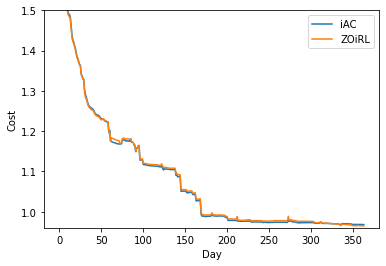

In [31]:
plt.plot(total, label="iAC")
plt.plot(ZO_iRL_costs[::24][1:], label="ZOiRL")
plt.legend()
plt.ylim(0.96, 1.5)
plt.xlabel("Day")
plt.ylabel("Cost")
plt.show()

In [89]:
np.where(ZO_iRL_costs[::24][1:] < total)

(array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
         27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
         40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  60,
         61,  85,  86,  87,  88, 327, 328, 329, 330, 331, 332, 333, 334,
        335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347,
        348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360,
        361, 362, 363]),)

In [42]:
-66989084.0,rewards[23:].sum()

(-66989084.0, -65382132.0)

In [15]:
data = {}
NUM_DAYS = len(agent.critic_optim.debug['ramping_cost'])

for key, _d in agent.critic_optim.debug.items():
    data[key] = []
    for day in _d:
        data[key].append(day.value)
    data[key] = np.reshape(data[key], (NUM_DAYS * 24))

In [ ]:
rc = data['ramping_cost']
peak = data['peak_net_electricity_cost']
ec = data['electricity_cost']

A = np.vstack((-rc, -peak)).T
y = np.reshape(agent.critic_optim.problem.param_dict['y_r'].value, (NUM_DAYS * 24))

x, residuals, rank, s = np.linalg.lstsq(A, y, rcond=None)
print(f"Rank: {rank}\tCondition Number: {np.linalg.cond(A)}")
print(f"MSE across {NUM_DAYS} days: {round(np.linalg.norm(A@x - y), 5)}")

plt.plot(A@x, label='y_hat')
plt.plot(y, label='y')
plt.legend()
plt.xlabel("Hours")
plt.ylabel("Q-value")
plt.show()

In [ ]:
(A@x).max(), y.max()

In [ ]:
p = agent.critic_optim.problem

In [ ]:
p.solve()

In [ ]:
import cvxpy
for i in range(len(p.constraints)):
    x = p.constraints[i]
    if isinstance(x.args[0], cvxpy.atoms.affine.add_expr.AddExpression):
        assert x.args[0].value <= 1, (i, x.args[0].value)

In [ ]:
agent.critic_target[0].alpha_peak1

In [ ]:
agent.critic_optim.debug

In [ ]:
np.mean(agent.critic[0].alpha_elec, 1)

In [ ]:
agent.critic_target[0].alpha_ramp

In [ ]:
agent.critic[0].alpha_ramp

In [ ]:
_t = np.array(agent._actor_zetas['p_ele_local']).T

In [ ]:
plt.scatter(range(24), agent.actor.zeta['p_ele'][:, 0], c='k', label="Iteration 3")
plt.bar(range(24), _t[0, :, 0], label="Initial")
plt.bar(range(24), _t[0, :, 1], label="Iteration 1")
plt.bar(range(24), _t[0, :, 2], label="Iteration 2")
plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=4)
plt.show()

In [ ]:
#set seaborn plotting aesthetics as default
sns.set(rc={'figure.figsize':(5,5)})
df = np.array(agent._actor_zetas['p_ele_local'])
df = np.append(df, np.expand_dims(agent.actor.zeta['p_ele'], 0)).reshape((9, 24, 9)).T

fig, axn = plt.subplots(2, 2, sharex=True, sharey=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i, ax in enumerate(axn.flat):
    sns.heatmap(df[i], ax=ax,
                cbar=i == 0,
                cmap='viridis',
                cbar_ax=None if i else cbar_ax)
    ax.set(title=f"Building {i + 1}")

axn.flat[0].set(ylabel='Hour of Day')
axn.flat[2].set(ylabel='Hour of Day')
axn.flat[2].set(xlabel='Month')
axn.flat[3].set(xlabel='Month')


fig.tight_layout(rect=[0, 0, .9, 1])

In [ ]:
plt.bar(range(24), agent.actor.zeta['p_ele'][:, 0])

In [ ]:
np.array(agent._actor_zetas["p_ele_local"])[:, :, 0].min(1)

In [ ]:
np.array(agent._actor_zetas["p_ele_target"])[:, :, 0].min(1)

In [ ]:
agent.actor.scs_cnt, agent.actor.fail_cnt, agent.critic_optim.fail_cnt

In [ ]:
agent.actor.zeta["p_ele"][:, 0]

In [ ]:
agent.critic[0].alpha_peak1

In [ ]:
agent.critic_target[0].alpha_peak1

In [ ]:
agent.actor.zeta

In [68]:
t = np.random.rand(101, 30)

In [69]:
v = np.expand_dims(t, axis=(2, 3))

In [74]:
np.linalg.matrix_rank(t)

30

In [76]:
total[100]

1.1169729594212834